# BAM Sample Size Estimation

**Bayesian Assurance Method (BAM) for Sample Size Determination**

This notebook estimates sample size requirements for future studies using:
1. **Real pilot data** - Sensitivity/specificity and AUC from bd_real.pkl
2. **Synthetic data** - Simulated scenarios for validation

## Objectives

- Estimate minimum sample sizes for **Sensitivity + Specificity** (joint estimation)
- Estimate minimum sample sizes for **AUC**
- Target HDI widths: **0.10, 0.15, 0.20**
- Target assurance levels: **0.80, 0.90**
- Generate Excel reports for grant applications
- Create visualizations (assurance curves, heatmaps)

## Methodology

**BAM Framework:**
- Hierarchical Bayesian model with Gamma hyperpriors
- Monte Carlo simulation (2000 iterations)
- Binary search for efficient N determination
- Joint constraints for sensitivity AND specificity

**Key Parameters:**
- `target_width`: HDI width (0.10 = ±5%, 0.15 = ±7.5%, 0.20 = ±10%)
- `target_assurance`: Probability of achieving target width (0.80 or 0.90)

---

## 1. Setup and Imports

In [1]:
# Standard library
from pathlib import Path
import pickle
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Scientific computing
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

# BAM modules
from early_markers.cribsy.common.bam_unified import (
    BAMEstimator,
    bam_grid_search,
    bam_grid_search_joint,
    BAMResult
)
from early_markers.cribsy.common.bam_export import (
    export_bam_results_to_excel
)

# Local modules
from early_markers.cribsy.common.bayes import BayesianData
from early_markers.cribsy.common.constants import (
    PKL_DIR,
    IPC_DIR,
    XLSX_DIR,
    PLOT_DIR,
    CSV_DIR,
    RAND_STATE
)

# Configure display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
pd.set_option('display.float_format', '{:.4f}'.format)

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Imports complete")
print(f"✓ Random seed: {RAND_STATE}")
print(f"✓ Data directory: {PKL_DIR}")
print(f"✓ Output directories: {XLSX_DIR}, {PLOT_DIR}")

✓ Imports complete
✓ Random seed: 20250313
✓ Data directory: /Volumes/secure/data/early_markers/cribsy/pkl
✓ Output directories: /Volumes/secure/data/early_markers/cribsy/xlsx, /Volumes/secure/data/early_markers/cribsy/png


---
## 2. Configuration

In [2]:
# BAM Configuration (as specified)
CONFIG = {
    # Target precision requirements
    'target_widths': [0.10, 0.15, 0.20],  # ±5%, ±7.5%, ±10%
    'target_assurances': [0.80, 0.90],    # 80%, 90%
    'ci_level': 0.95,                     # 95% credible interval

    # Simulation parameters
    'simulations': 2000,       # Monte Carlo iterations
    'simulations_joint': 1000, # Lower for joint (slower)
    'max_sample': 10000,       # Maximum N to consider

    # For joint (Se+Sp) estimation
    'prevalence_priors': [
        (5, 20),   # Beta(5, 20) ≈ 20% prevalence
        (8, 32),   # Beta(8, 32) ≈ 20% prevalence (stronger prior)
        (10, 40),  # Beta(10, 40) ≈ 20% prevalence (strongest prior)
    ],

    # Parallel processing
    'n_jobs': -1,  # Use all CPU cores

    # Random seed
    'seed': RAND_STATE,
}

# Display configuration
print("BAM Configuration:")
print("=" * 60)
print(f"  Target HDI Widths:       {CONFIG['target_widths']}")
print(f"  Target Assurance Levels: {CONFIG['target_assurances']}")
print(f"  CI Level:                {CONFIG['ci_level']}")
print(f"  Simulations (single):    {CONFIG['simulations']}")
print(f"  Simulations (joint):     {CONFIG['simulations_joint']}")
print(f"  Prevalence Priors:       {CONFIG['prevalence_priors']}")
print(f"  Random Seed:             {CONFIG['seed']}")
print("=" * 60)

BAM Configuration:
  Target HDI Widths:       [0.1, 0.15, 0.2]
  Target Assurance Levels: [0.8, 0.9]
  CI Level:                0.95
  Simulations (single):    2000
  Simulations (joint):     1000
  Prevalence Priors:       [(5, 20), (8, 32), (10, 40)]
  Random Seed:             20250313


---
## 3. Load Real Data (bd_real.pkl)

In [3]:
# Load BayesianData with computed metrics
real_data_file = PKL_DIR / "bd_real.pkl"

if not real_data_file.exists():
    raise FileNotFoundError(
        f"Real data file not found: {real_data_file}\n"
        "Please run notebooks 01_rfe_real.ipynb and outcomes analysis first."
    )

print(f"Loading: {real_data_file}")
with open(real_data_file, 'rb') as f:
    bd_real = pickle.load(f)

# Check available metrics
available_metrics = list(bd_real._metrics.keys())
print(f"\n✓ Data loaded successfully")
print(f"Available metric sets: {available_metrics}")

if not available_metrics:
    raise ValueError(
        "No metrics found in bd_real.pkl. "
        "Run RFE and metrics computation first."
    )

# Use first available metrics (or specify a particular one)
metrics_name = available_metrics[0]
metrics_df = bd_real.metrics_df(metrics_name)

print(f"\nUsing metrics: {metrics_name}")
print(f"Total thresholds: {len(metrics_df)}")
print(f"\nMetrics preview:")
display(metrics_df[['threshold', 'sens', 'spec', 'ppv', 'npv', 'j']].head(10))

Loading: /Volumes/secure/data/early_markers/cribsy/pkl/bd_real.pkl

✓ Data loaded successfully
Available metric sets: ['real_k_54', 'real_k_48', 'real_k_45', 'real_k_40', 'real_k_34', 'real_k_24', 'real_k_15', 'real_k_7']

Using metrics: real_k_54
Total thresholds: 54

Metrics preview:


threshold,sens,spec,ppv,npv,j
f64,f64,f64,f64,f64,f64
1.081799,1.0,0.025,0.264151,1.0,0.025
0.838178,1.0,0.05,0.269231,1.0,0.05
0.797692,1.0,0.075,0.27451,1.0,0.075
0.768654,1.0,0.1,0.28,1.0,0.1
0.765831,1.0,0.125,0.285714,1.0,0.125
0.727357,1.0,0.15,0.291667,1.0,0.15
0.653154,1.0,0.175,0.297872,1.0,0.175
0.531648,1.0,0.2,0.304348,1.0,0.2
0.51559,1.0,0.225,0.311111,1.0,0.225


---
## 4. Extract Pilot Metrics from Real Data

Extract sensitivity, specificity, and sample sizes at optimal threshold (Youden's J).

In [4]:
# Find optimal threshold (Youden's J = sensitivity + specificity - 1)
# Note: 'j' column already exists in metrics_df (Youden's J)
optimal_row_df = metrics_df.filter(pl.col('j') == pl.col('j').max())
if optimal_row_df.height > 1:
    # If multiple thresholds have same J, pick the one with highest threshold
    optimal_row_df = optimal_row_df.filter(pl.col('threshold') == pl.col('threshold').max())
optimal_row = optimal_row_df.row(0, named=True)

# Extract metrics
pilot_se_real = optimal_row['sens']
pilot_sp_real = optimal_row['spec']
optimal_threshold = optimal_row['threshold']
youdens_j = optimal_row['j']

# Get AUC from the ROCResult (not in metrics_df)
roc_result = bd_real._metrics[metrics_name]
pilot_auc_real = roc_result.auc

# Get confusion matrix from primitives DataFrame
primitives_df = roc_result.primitives
primitives_row_df = primitives_df.filter(pl.col('thresh') == optimal_threshold)
if primitives_row_df.height > 0:
    primitives_row = primitives_row_df.row(0, named=True)
    tp_real = int(primitives_row['tp'])
    fn_real = int(primitives_row['fn'])
    tn_real = int(primitives_row['tn'])
    fp_real = int(primitives_row['fp'])
else:
    # Fallback if not found
    tp_real = fn_real = tn_real = fp_real = 0

# Calculate totals
condition_positives_real = tp_real + fn_real  # Diseased
condition_negatives_real = tn_real + fp_real  # Non-diseased
total_n_real = condition_positives_real + condition_negatives_real
prevalence_real = condition_positives_real / total_n_real if total_n_real > 0 else 0

# Format for BAM
pilot_se_tuple_real = (tp_real, condition_positives_real)
pilot_sp_tuple_real = (tn_real, condition_negatives_real)

# For AUC estimation, create binary array based on overall accuracy
# (This is approximate - BAM single metric treats as binary success/failure)
correct_classifications = tp_real + tn_real
pilot_array_auc_real = np.array([1] * correct_classifications + [0] * (total_n_real - correct_classifications))

# Display pilot data
print("\n" + "=" * 60)
print("REAL PILOT DATA (Optimal Threshold = Youden's J)")
print("=" * 60)
print(f"  Optimal Threshold:     {optimal_threshold:.4f}")
print(f"  Youden's J:            {youdens_j:.4f}")
print()
print(f"  Sensitivity:           {pilot_se_real:.4f} = {tp_real}/{condition_positives_real}")
print(f"  Specificity:           {pilot_sp_real:.4f} = {tn_real}/{condition_negatives_real}")
print(f"  AUC:                   {pilot_auc_real:.4f}")
print()
print(f"  Total Sample Size:     {total_n_real}")
print(f"  Diseased (P):          {condition_positives_real} ({prevalence_real:.1%})")
print(f"  Non-diseased (N):      {condition_negatives_real} ({1-prevalence_real:.1%})")
print()
print(f"  Confusion Matrix:      TP={tp_real}, FN={fn_real}, TN={tn_real}, FP={fp_real}")
print("=" * 60)



REAL PILOT DATA (Optimal Threshold = Youden's J)
  Optimal Threshold:     -0.0334
  Youden's J:            0.5321

  Sensitivity:           0.8571 = 12/14
  Specificity:           0.6750 = 27/40
  AUC:                   0.7875

  Total Sample Size:     54
  Diseased (P):          14 (25.9%)
  Non-diseased (N):      40 (74.1%)

  Confusion Matrix:      TP=12, FN=2, TN=27, FP=13


---
## 5. BAM: Joint Estimation (Se + Sp) - Real Data

Estimate sample sizes when **BOTH** sensitivity AND specificity must meet precision requirements.

In [5]:
# Initialize estimator
estimator_real = BAMEstimator(seed=CONFIG['seed'], verbose=False)

# Single estimation example (width=0.15, assurance=0.80)
print("\n" + "=" * 70)
print("SINGLE JOINT ESTIMATION (Se + Sp) - Real Data")
print("Target: width=0.15, assurance=0.80")
print("=" * 70 + "\n")

result_real_joint_example = estimator_real.estimate_joint(
    pilot_se=pilot_se_tuple_real,
    pilot_sp=pilot_sp_tuple_real,
    target_width=0.15,
    ci=CONFIG['ci_level'],
    target_assurance=0.80,
    prevalence_prior=(8, 32),  # 20% prevalence
    simulations=CONFIG['simulations_joint']
)

print("RESULTS:")
print(f"  Optimal N (TOTAL):      {result_real_joint_example.optimal_n}")
print(f"  Achieved Assurance:     {result_real_joint_example.achieved_assurance:.2%}")
print(f"  Computation Time:       {result_real_joint_example.computation_time:.1f}s")
print()
print("  Sample Allocation (20% prevalence):")
print(f"    Diseased (P):         ~{int(result_real_joint_example.optimal_n * 0.2)}")
print(f"    Non-diseased (N):     ~{int(result_real_joint_example.optimal_n * 0.8)}")
print("=" * 70)


SINGLE JOINT ESTIMATION (Se + Sp) - Real Data
Target: width=0.15, assurance=0.80

RESULTS:
  Optimal N (TOTAL):      619
  Achieved Assurance:     80.80%
  Computation Time:       21.9s

  Sample Allocation (20% prevalence):
    Diseased (P):         ~123
    Non-diseased (N):     ~495


### 5.1 Grid Search: Joint (Se + Sp) - All Configurations

In [6]:
print("\n" + "=" * 70)
print("GRID SEARCH - Joint (Se + Sp) - Real Data")
print("=" * 70)
print(f"\nExploring {len(CONFIG['target_widths'])} widths × "
      f"{len(CONFIG['target_assurances'])} assurances × "
      f"{len(CONFIG['prevalence_priors'])} prevalence priors")
print(f"Total combinations: {len(CONFIG['target_widths']) * len(CONFIG['target_assurances']) * len(CONFIG['prevalence_priors'])}")
print(f"\nThis may take several minutes with parallel processing...\n")

grid_real_joint = bam_grid_search_joint(
    pilot_se=pilot_se_tuple_real,
    pilot_sp=pilot_sp_tuple_real,
    target_widths=CONFIG['target_widths'],
    target_assurances=CONFIG['target_assurances'],
    prevalence_priors=CONFIG['prevalence_priors'],
    ci_levels=[CONFIG['ci_level']],
    simulations=CONFIG['simulations_joint'],
    seed=CONFIG['seed'],
    n_jobs=CONFIG['n_jobs'],
    verbose=True
)

print("\n" + "=" * 70)
print("GRID RESULTS")
print("=" * 70)
# Create prevalence_prior string column for grouping
grid_real_joint["prevalence_prior"] = grid_real_joint.apply(
    lambda row: f"Beta({int(row["prevalence_prior_alpha"])}, {int(row["prevalence_prior_beta"])})",
    axis=1
)

display(grid_real_joint)

# Pivot tables for each prevalence prior
print("\n" + "=" * 70)
print("SAMPLE SIZE MATRICES (Rows=Assurance, Cols=Width)")
print("=" * 70)

for prev_str in sorted(grid_real_joint['prevalence_prior'].unique()):
    print(f"\n{prev_str}:")
    print("-" * 50)
    subset = grid_real_joint[grid_real_joint['prevalence_prior'] == prev_str]
    pivot = subset.pivot(
        index='target_assurance',
        columns='target_width',
        values='optimal_n'
    )
    display(pivot)


GRID SEARCH - Joint (Se + Sp) - Real Data

Exploring 3 widths × 2 assurances × 3 prevalence priors
Total combinations: 18

This may take several minutes with parallel processing...

Running grid search over 18 parameter combinations...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  18 | elapsed:   27.2s remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   5 out of  18 | elapsed:   27.3s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:   27.6s remaining:   43.3s
[Parallel(n_jobs=-1)]: Done   9 out of  18 | elapsed:   28.0s remaining:   28.0s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:   28.8s remaining:   18.3s
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:   28.9s remaining:   11.1s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:   29.3s remaining:    5.9s



GRID RESULTS


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   47.6s finished


,target_width,target_assurance,prevalence_prior_alpha,prevalence_prior_beta,ci_level,optimal_n,achieved_assurance,computation_time,pilot_estimate,prevalence_prior
0,0.1000,0.8000,5,20,0.9500,1719,0.8160,27.8086,0.7661,"Beta(5, 20)"
1,0.1000,0.8000,8,32,0.9500,1572,0.8180,27.6596,0.7661,"Beta(8, 32)"
2,0.1000,0.8000,10,40,0.9500,1549,0.8150,25.6389,0.7661,"Beta(10, 40)"
3,0.1000,0.9000,5,20,0.9500,2126,0.9010,26.1335,0.7661,"Beta(5, 20)"
4,0.1000,0.9000,8,32,0.9500,1941,0.9160,25.6818,0.7661,"Beta(8, 32)"
5,0.1000,0.9000,10,40,0.9500,1839,0.9090,27.9032,0.7661,"Beta(10, 40)"
6,0.1500,0.8000,5,20,0.9500,686,0.8300,27.9152,0.7661,"Beta(5, 20)"
7,0.1500,0.8000,8,32,0.9500,619,0.8080,26.5486,0.7661,"Beta(8, 32)"
8,0.1500,0.8000,10,40,0.9500,600,0.8020,26.4357,0.7661,"Beta(10, 40)"
9,0.1500,0.9000,5,20,0.9500,882,0.9070,28.4259,0.7661,"Beta(5, 20)"



SAMPLE SIZE MATRICES (Rows=Assurance, Cols=Width)

Beta(10, 40):
--------------------------------------------------


target_width,0.1000,0.1500,0.2000
target_assurance,,,
0.8000,1549,600,300
0.9000,1839,763,373



Beta(5, 20):
--------------------------------------------------


target_width,0.1000,0.1500,0.2000
target_assurance,,,
0.8000,1719,686,325
0.9000,2126,882,402



Beta(8, 32):
--------------------------------------------------


target_width,0.1000,0.1500,0.2000
target_assurance,,,
0.8000,1572,619,306
0.9000,1941,786,382


---
## 6. BAM: AUC Estimation - Real Data

Treat AUC as a single binary metric for sample size estimation.

In [7]:
# For AUC, use overall classification accuracy as proxy
print("\n" + "=" * 70)
print("SINGLE AUC ESTIMATION - Real Data")
print("Target: width=0.15, assurance=0.80")
print("=" * 70 + "\n")
print(f"Note: Using classification accuracy ({(tp_real + tn_real)/total_n_real:.2%}) as proxy for AUC")
print()

result_real_auc_example = estimator_real.estimate_single(
    pilot_data=pilot_array_auc_real,
    target_width=0.15,
    ci=CONFIG['ci_level'],
    target_assurance=0.80,
    simulations=CONFIG['simulations']
)

print("RESULTS:")
print(f"  Optimal N:              {result_real_auc_example.optimal_n}")
print(f"  Achieved Assurance:     {result_real_auc_example.achieved_assurance:.2%}")
print(f"  Pilot Estimate:         {result_real_auc_example.pilot_estimate:.4f}")
print(f"  Actual Pilot AUC:       {pilot_auc_real:.4f}")
print(f"  Computation Time:       {result_real_auc_example.computation_time:.1f}s")
print("=" * 70)


SINGLE AUC ESTIMATION - Real Data
Target: width=0.15, assurance=0.80

Note: Using classification accuracy (72.22%) as proxy for AUC

RESULTS:
  Optimal N:              92
  Achieved Assurance:     80.70%
  Pilot Estimate:         0.7222
  Actual Pilot AUC:       0.7875
  Computation Time:       22.0s


### 6.1 Grid Search: AUC - All Configurations

In [8]:
print("\n" + "=" * 70)
print("GRID SEARCH - AUC - Real Data")
print("=" * 70 + "\n")

grid_real_auc = bam_grid_search(
    pilot_data=pilot_array_auc_real,
    target_widths=CONFIG['target_widths'],
    target_assurances=CONFIG['target_assurances'],
    ci_levels=[CONFIG['ci_level']],
    simulations=CONFIG['simulations'],
    seed=CONFIG['seed'],
    n_jobs=CONFIG['n_jobs'],
    verbose=True
)

print("\n" + "=" * 70)
print("GRID RESULTS - AUC")
print("=" * 70)
display(grid_real_auc)

print("\nSAMPLE SIZE MATRIX (Rows=Assurance, Cols=Width):")
print("-" * 50)
pivot_auc = grid_real_auc.pivot(
    index='target_assurance',
    columns='target_width',
    values='optimal_n'
)
display(pivot_auc)


GRID SEARCH - AUC - Real Data

Running grid search over 6 parameter combinations...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



GRID RESULTS - AUC


[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:   21.5s remaining:   43.0s
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   21.5s remaining:   21.5s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:   21.6s remaining:   10.8s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   21.6s finished


,target_width,target_assurance,ci_level,optimal_n,achieved_assurance,computation_time,pilot_estimate
0,0.1000,0.8000,0.9500,280,0.8080,21.3908,0.7222
1,0.1000,0.9000,0.9500,293,0.9080,21.5122,0.7222
2,0.1500,0.8000,0.9500,92,0.8220,21.5983,0.7222
3,0.1500,0.9000,0.9500,97,0.9015,21.4993,0.7222
4,0.2000,0.8000,0.9500,50,1.0000,21.6231,0.7222
5,0.2000,0.9000,0.9500,50,1.0000,21.5800,0.7222



SAMPLE SIZE MATRIX (Rows=Assurance, Cols=Width):
--------------------------------------------------


target_width,0.1000,0.1500,0.2000
target_assurance,,,
0.8000,280,92,50
0.9000,293,97,50


---
## 7. Load and Analyze Synthetic Data

In [9]:
# Try to load synthetic data
synthetic_files = list(IPC_DIR.glob("synth*.ipc"))

bd_synthetic = None
if synthetic_files:
    synth_file = synthetic_files[0]  # Use first available
    print(f"Loading synthetic data: {synth_file.name}")
    try:
        bd_synthetic = BayesianData(base_file=synth_file.name, synthetic=True)
        print(f"✓ Loaded {len(bd_synthetic._base)} records")

        # Quick RFE if needed
        if not bd_synthetic._rfes:
            print("  Running RFE...")
            bd_synthetic.run_rfe_on_base("rfe_synth", features_to_keep_pct=0.9)

        # Get RFE and run surprise + metrics
        rfe_name = list(bd_synthetic._rfes.keys())[0]
        k = bd_synthetic.rfe_k(rfe_name)
        model_name = f"model_synth_k_{k}"

        if model_name not in bd_synthetic._frames:
            print("  Computing surprise...")
            bd_synthetic.run_surprise_with_rfe("model_synth", rfe_name)

        metrics_name_synth = f"metrics_synth_k_{k}"
        if metrics_name_synth not in bd_synthetic._metrics:
            print("  Computing metrics...")
            bd_synthetic.run_metrics_from_surprise(metrics_name_synth, model_name)

        metrics_synth_df = bd_synthetic.metrics_df(metrics_name_synth)
        print("\n✓ Synthetic data ready")
        print(f"  Features: {k}")
        print(f"  Thresholds: {len(metrics_synth_df)}")

    except Exception as e:
        print(f"  ⚠️ Error processing synthetic data: {e}")
        bd_synthetic = None
else:
    print("⚠️ No synthetic data files found in {IPC_DIR}")
    print("   Skipping synthetic data analysis.")

Loading synthetic data: synth_sdv_400_long.ipc
  ⚠️ Error processing synthetic data: BayesianData.__init__() got an unexpected keyword argument 'synthetic'


### 7.1 Extract Synthetic Pilot Metrics

In [10]:
if bd_synthetic is not None and 'metrics_synth_df' in locals():
    # Find optimal threshold
    metrics_synth_df['youden_j'] = metrics_synth_df['sens'] + metrics_synth_df['spec'] - 1
    optimal_idx_synth = metrics_synth_df['youden_j'].idxmax()
    optimal_row_synth = metrics_synth_df.loc[optimal_idx_synth]

    # Extract metrics
    pilot_se_synth = optimal_row_synth['sens']
    pilot_sp_synth = optimal_row_synth['spec']
    pilot_auc_synth = optimal_row_synth['auc']

    tp_synth = int(optimal_row_synth.get('tp', optimal_row_synth.get('TP', 0)))
    fn_synth = int(optimal_row_synth.get('fn', optimal_row_synth.get('FN', 0)))
    tn_synth = int(optimal_row_synth.get('tn', optimal_row_synth.get('TN', 0)))
    fp_synth = int(optimal_row_synth.get('fp', optimal_row_synth.get('FP', 0)))

    condition_positives_synth = tp_synth + fn_synth
    condition_negatives_synth = tn_synth + fp_synth
    total_n_synth = condition_positives_synth + condition_negatives_synth

    pilot_se_tuple_synth = (tp_synth, condition_positives_synth)
    pilot_sp_tuple_synth = (tn_synth, condition_negatives_synth)

    print("\n" + "=" * 60)
    print("SYNTHETIC PILOT DATA")
    print("=" * 60)
    print(f"  Sensitivity:           {pilot_se_synth:.4f}")
    print(f"  Specificity:           {pilot_sp_synth:.4f}")
    print(f"  AUC:                   {pilot_auc_synth:.4f}")
    print(f"  Total Sample:          {total_n_synth}")
    print("=" * 60)

    synthetic_available = True
else:
    print("Synthetic data not available")
    synthetic_available = False

Synthetic data not available


### 7.2 BAM: Joint (Se + Sp) - Synthetic Data

In [11]:
if synthetic_available:
    estimator_synth = BAMEstimator(seed=CONFIG['seed'], verbose=False)

    print("\n" + "=" * 70)
    print("JOINT ESTIMATION (Se + Sp) - Synthetic Data")
    print("=" * 70 + "\n")

    result_synth_joint = estimator_synth.estimate_joint(
        pilot_se=pilot_se_tuple_synth,
        pilot_sp=pilot_sp_tuple_synth,
        target_width=0.15,
        ci=CONFIG['ci_level'],
        target_assurance=0.80,
        prevalence_prior=(8, 32),
        simulations=CONFIG['simulations_joint']
    )

    print("RESULTS:")
    print(f"  Optimal N (TOTAL):      {result_synth_joint.optimal_n}")
    print(f"  Achieved Assurance:     {result_synth_joint.achieved_assurance:.2%}")
    print(f"  Computation Time:       {result_synth_joint.computation_time:.1f}s")
    print("=" * 70)
else:
    print("Skipping synthetic BAM")

Skipping synthetic BAM


---
## 8. Comparison: Real vs Synthetic

In [12]:
if synthetic_available:
    comparison_df = pd.DataFrame({
        'Metric': ['Sensitivity', 'Specificity', 'AUC', 'Sample N (Se+Sp, 0.15, 0.80)'],
        'Real Data': [
            f"{pilot_se_real:.4f}",
            f"{pilot_sp_real:.4f}",
            f"{pilot_auc_real:.4f}",
            f"{result_real_joint_example.optimal_n}"
        ],
        'Synthetic Data': [
            f"{pilot_se_synth:.4f}",
            f"{pilot_sp_synth:.4f}",
            f"{pilot_auc_synth:.4f}",
            f"{result_synth_joint.optimal_n}"
        ]
    })

    print("\n" + "=" * 70)
    print("REAL vs SYNTHETIC COMPARISON")
    print("=" * 70)
    display(comparison_df)

    diff = result_synth_joint.optimal_n - result_real_joint_example.optimal_n
    pct_diff = (diff / result_real_joint_example.optimal_n) * 100
    print(f"\nSample size difference: {diff:+d} ({pct_diff:+.1f}%)")
else:
    print("Cannot compare - synthetic data not available")

Cannot compare - synthetic data not available


---
## 9. Visualizations

### 9.1 Assurance Curves

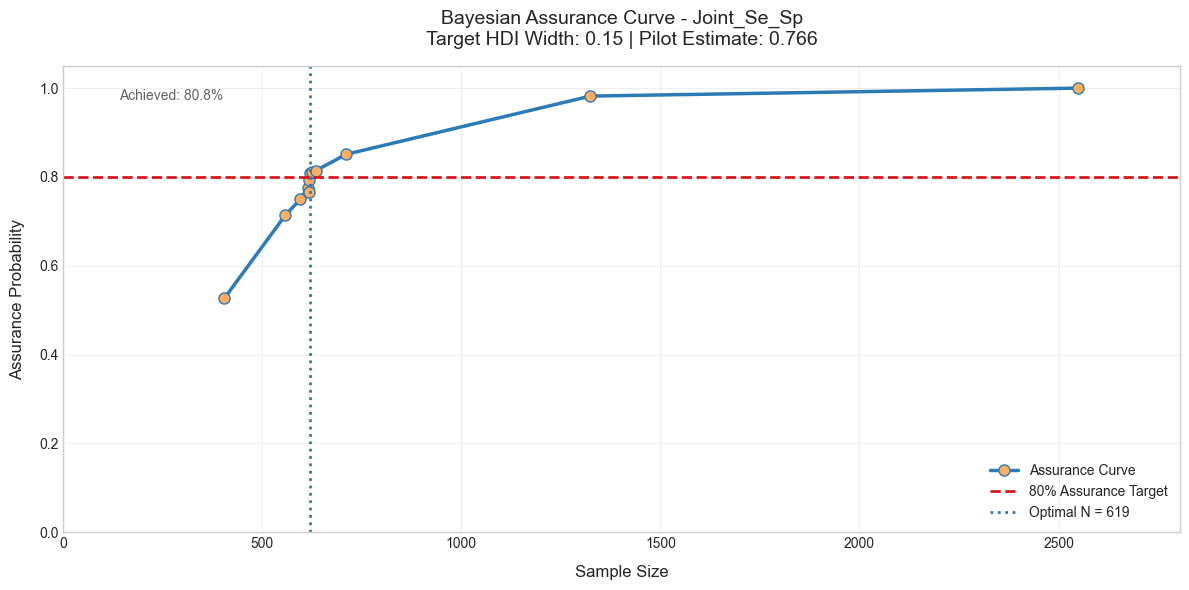

<Figure size 640x480 with 0 Axes>

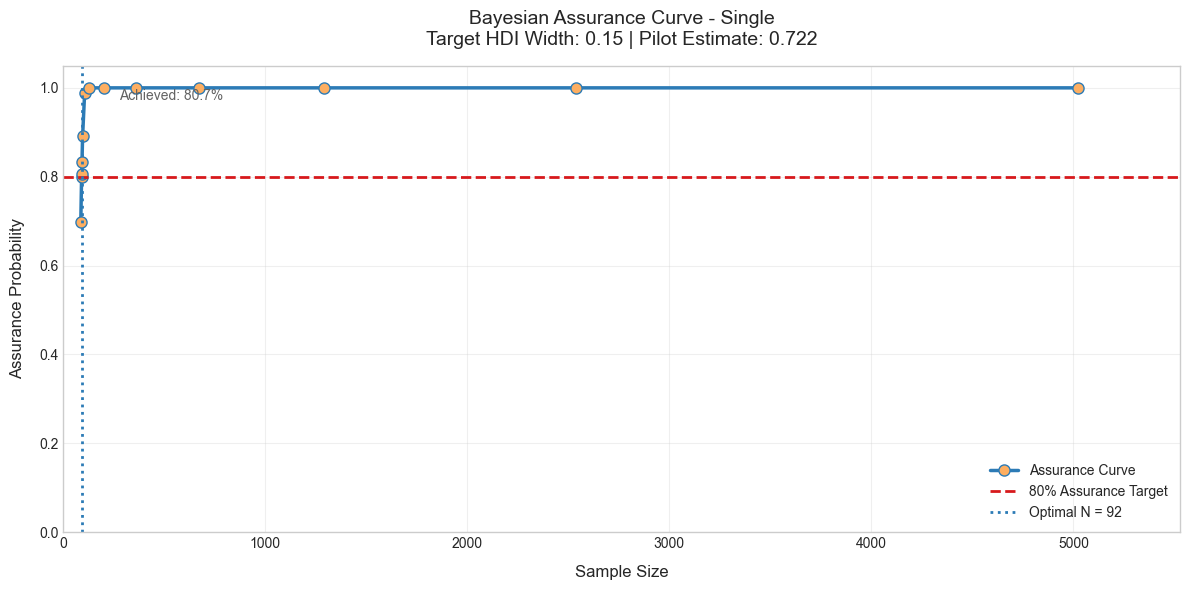

<Figure size 640x480 with 0 Axes>

In [13]:
# Plot assurance curve for real data joint estimation
fig = result_real_joint_example.plot(
    save_path=PLOT_DIR / "bam_real_joint_assurance.png"
)
plt.tight_layout()
plt.show()

# Plot for AUC
fig = result_real_auc_example.plot(
    save_path=PLOT_DIR / "bam_real_auc_assurance.png"
)
plt.tight_layout()
plt.show()

if synthetic_available:
    fig = result_synth_joint.plot(
        save_path=PLOT_DIR / "bam_synth_joint_assurance.png"
    )
    plt.tight_layout()
    plt.show()

### 9.2 Sample Size Heatmaps

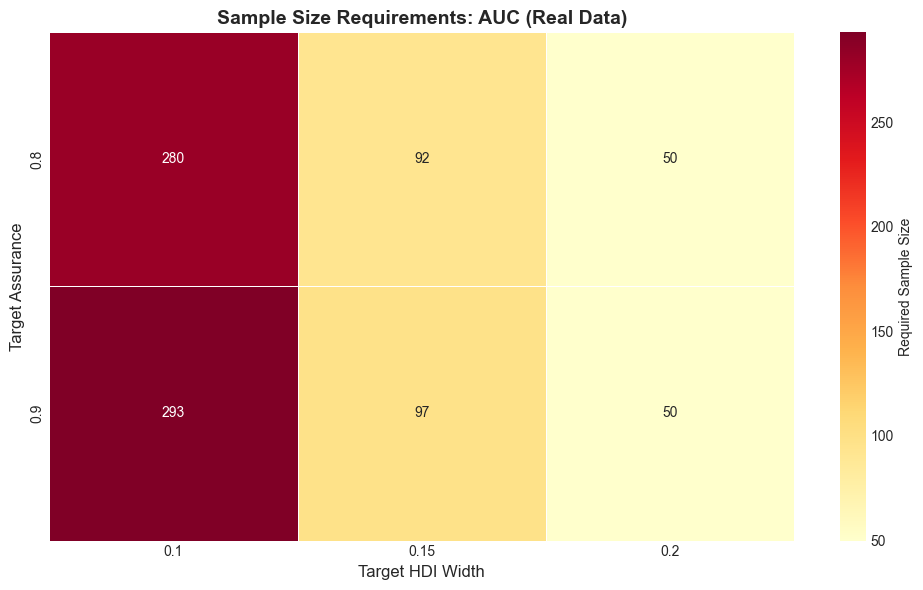

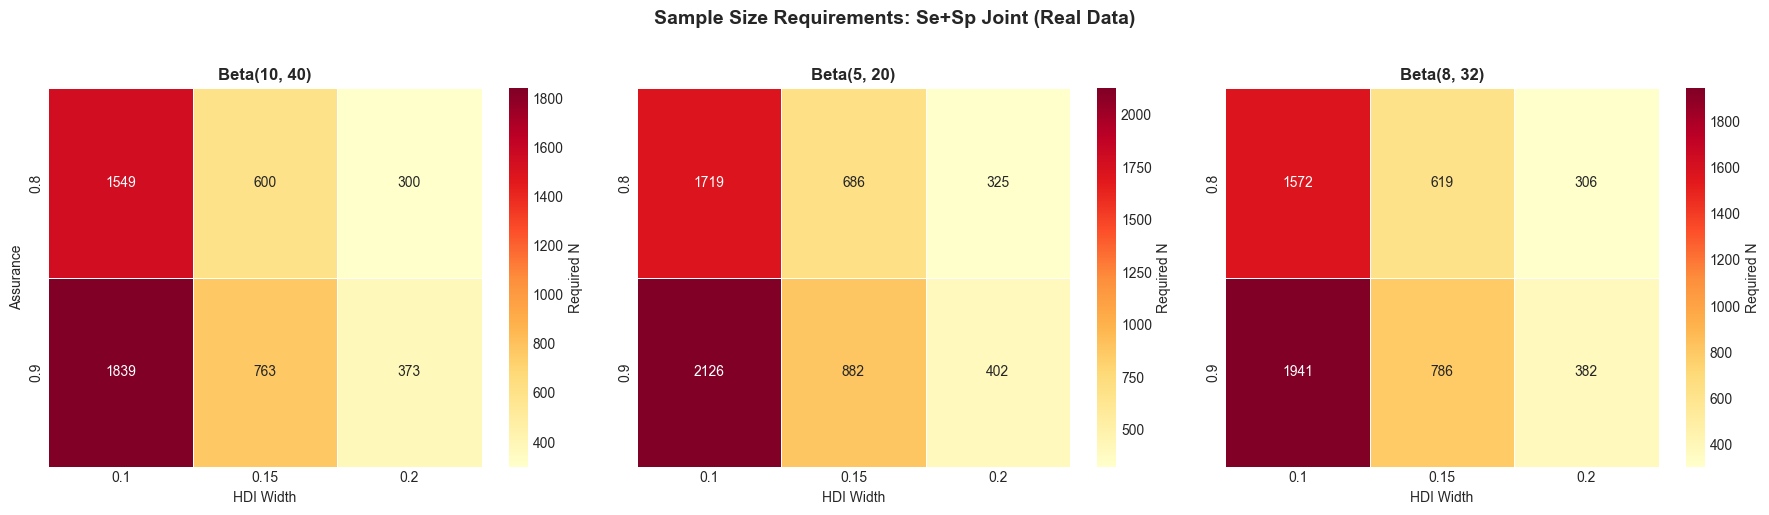

In [14]:
# Heatmap for AUC (simpler - no prevalence dimension)
fig, ax = plt.subplots(figsize=(10, 6))

pivot_auc_plot = grid_real_auc.pivot(
    index='target_assurance',
    columns='target_width',
    values='optimal_n'
)

sns.heatmap(
    pivot_auc_plot,
    annot=True,
    fmt='d',
    cmap='YlOrRd',
    cbar_kws={'label': 'Required Sample Size'},
    ax=ax,
    linewidths=0.5
)

ax.set_title('Sample Size Requirements: AUC (Real Data)',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Target HDI Width', fontsize=12)
ax.set_ylabel('Target Assurance', fontsize=12)

plt.tight_layout()
plt.savefig(PLOT_DIR / "bam_real_auc_heatmap.png", dpi=150, bbox_inches='tight')
plt.show()

# Heatmaps for Se+Sp at each prevalence prior
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, prev_str in enumerate(sorted(grid_real_joint['prevalence_prior'].unique())):
    ax = axes[idx]
    subset = grid_real_joint[grid_real_joint['prevalence_prior'] == prev_str]
    pivot = subset.pivot(
        index='target_assurance',
        columns='target_width',
        values='optimal_n'
    )

    sns.heatmap(
        pivot,
        annot=True,
        fmt='d',
        cmap='YlOrRd',
        cbar_kws={'label': 'Required N'},
        ax=ax,
        linewidths=0.5
    )

    ax.set_title(f'{prev_str}', fontsize=12, fontweight='bold')
    ax.set_xlabel('HDI Width', fontsize=10)
    ax.set_ylabel('Assurance' if idx == 0 else '', fontsize=10)

fig.suptitle('Sample Size Requirements: Se+Sp Joint (Real Data)',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(PLOT_DIR / "bam_real_joint_heatmap.png", dpi=150, bbox_inches='tight')
plt.show()

---
## 10. Export Results to Excel

In [15]:
# Collect all BAMResult objects
all_results = [
    result_real_joint_example,
    result_real_auc_example,
]

if synthetic_available:
    all_results.append(result_synth_joint)

# Export to Excel
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
excel_file = XLSX_DIR / f"bam_sample_size_analysis_{timestamp}.xlsx"

export_bam_results_to_excel(
    results=all_results,
    output_path=excel_file,
    title="BAM Sample Size Analysis - Early Infant Movement Markers"
)

print(f"\n✓ Excel report exported: {excel_file}")
print(f"  Contents: Summary sheet + {len(all_results)} detailed result sheets")

Exported 2 BAM results to: /Volumes/secure/data/early_markers/cribsy/xlsx/bam_sample_size_analysis_20251005_2013.xlsx

✓ Excel report exported: /Volumes/secure/data/early_markers/cribsy/xlsx/bam_sample_size_analysis_20251005_2013.xlsx
  Contents: Summary sheet + 2 detailed result sheets


### 10.1 Export Grid Results to CSV

In [16]:
# Export grid results
csv_joint = CSV_DIR / "bam_grid_real_joint_se_sp.csv"
grid_real_joint.to_csv(csv_joint, index=False)
print(f"✓ Exported: {csv_joint}")

csv_auc = CSV_DIR / "bam_grid_real_auc.csv"
grid_real_auc.to_csv(csv_auc, index=False)
print(f"✓ Exported: {csv_auc}")

if synthetic_available and 'result_synth_joint' in locals():
    # Save single synthetic result
    synth_result_df = pd.DataFrame([{
        'metric_type': 'joint_se_sp',
        'data_source': 'synthetic',
        'optimal_n': result_synth_joint.optimal_n,
        'target_width': result_synth_joint.target_width,
        'target_assurance': result_synth_joint.target_assurance,
        'achieved_assurance': result_synth_joint.achieved_assurance,
        'pilot_se': pilot_se_synth,
        'pilot_sp': pilot_sp_synth,
    }])
    csv_synth = CSV_DIR / "bam_synthetic_result.csv"
    synth_result_df.to_csv(csv_synth, index=False)
    print(f"✓ Exported: {csv_synth}")

✓ Exported: /Volumes/secure/data/early_markers/cribsy/csv/bam_grid_real_joint_se_sp.csv
✓ Exported: /Volumes/secure/data/early_markers/cribsy/csv/bam_grid_real_auc.csv


---
## 11. Summary and Recommendations

In [17]:
print("\n" + "=" * 70)
print("SUMMARY AND RECOMMENDATIONS")
print("=" * 70 + "\n")

print("REAL DATA PILOT METRICS:")
print(f"  Sensitivity:     {pilot_se_real:.4f}")
print(f"  Specificity:     {pilot_sp_real:.4f}")
print(f"  AUC:             {pilot_auc_real:.4f}")
print(f"  Sample size:     {total_n_real}")
print()

print("SAMPLE SIZE ESTIMATES (width=0.15, assurance=0.80):")
print(f"  Se+Sp (Joint):   N = {result_real_joint_example.optimal_n}")
print(f"  AUC:             N = {result_real_auc_example.optimal_n}")
print()

# Find min and max from grid
min_n_joint = grid_real_joint['optimal_n'].min()
max_n_joint = grid_real_joint['optimal_n'].max()
min_n_auc = grid_real_auc['optimal_n'].min()
max_n_auc = grid_real_auc['optimal_n'].max()

print("RANGE ACROSS ALL CONFIGURATIONS:")
print(f"  Se+Sp (Joint):   {min_n_joint} - {max_n_joint}")
print(f"  AUC:             {min_n_auc} - {max_n_auc}")
print()

print("INTERPRETATION:")
print("  • Target width 0.10 = ±5% precision (most stringent)")
print("  • Target width 0.15 = ±7.5% precision (moderate)")
print("  • Target width 0.20 = ±10% precision (exploratory)")
print("  • Assurance 0.80 = 80% probability (standard, like 80% power)")
print("  • Assurance 0.90 = 90% probability (conservative)")
print("  • Joint estimation requires BOTH Se AND Sp to meet targets")
print()

print("RECOMMENDATIONS FOR GRANT APPLICATION:")
print()
print(f"  Option 1 (Conservative): N = {max_n_joint}")
print(f"    - Highest precision (width=0.10) + highest assurance (0.90)")
print(f"    - Use for regulatory submissions or high-stakes studies")
print()
print(f"  Option 2 (Recommended): N = {result_real_joint_example.optimal_n}")
print(f"    - Balanced precision (width=0.15) + standard assurance (0.80)")
print(f"    - Comparable to 80% power in frequentist framework")
print(f"    - Appropriate for most diagnostic accuracy studies")
print()
print(f"  Option 3 (With Attrition): N = {int(result_real_joint_example.optimal_n * 1.15)}")
print(f"    - Adds 15% buffer for dropout/missing data")
print(f"    - Recommended for longitudinal studies")
print()

print("PREVALENCE CONSIDERATIONS:")
print(f"  Current pilot prevalence: {prevalence_real:.1%}")
print(f"  For N={result_real_joint_example.optimal_n} with 20% prevalence:")
print(f"    - Diseased:     ~{int(result_real_joint_example.optimal_n * 0.2)}")
print(f"    - Non-diseased: ~{int(result_real_joint_example.optimal_n * 0.8)}")
print()

print("NEXT STEPS:")
print("  1. Review Excel export for detailed tables and visualizations")
print("  2. Consult with statistician on appropriate precision requirements")
print("  3. Consider study logistics (recruitment feasibility, timeline, budget)")
print("  4. For clustered designs, use estimate_joint_clustered() with ICC")
print("  5. Validate with frequentist power analysis for regulatory submissions")
print()

print("OUTPUT FILES:")
print(f"  Excel:  {excel_file.name}")
print(f"  CSV:    bam_grid_real_joint_se_sp.csv, bam_grid_real_auc.csv")
print(f"  Plots:  bam_real_*_assurance.png, bam_real_*_heatmap.png")
print()
print("=" * 70)


SUMMARY AND RECOMMENDATIONS

REAL DATA PILOT METRICS:
  Sensitivity:     0.8571
  Specificity:     0.6750
  AUC:             0.7875
  Sample size:     54

SAMPLE SIZE ESTIMATES (width=0.15, assurance=0.80):
  Se+Sp (Joint):   N = 619
  AUC:             N = 92

RANGE ACROSS ALL CONFIGURATIONS:
  Se+Sp (Joint):   300 - 2126
  AUC:             50 - 293

INTERPRETATION:
  • Target width 0.10 = ±5% precision (most stringent)
  • Target width 0.15 = ±7.5% precision (moderate)
  • Target width 0.20 = ±10% precision (exploratory)
  • Assurance 0.80 = 80% probability (standard, like 80% power)
  • Assurance 0.90 = 90% probability (conservative)
  • Joint estimation requires BOTH Se AND Sp to meet targets

RECOMMENDATIONS FOR GRANT APPLICATION:

  Option 1 (Conservative): N = 2126
    - Highest precision (width=0.10) + highest assurance (0.90)
    - Use for regulatory submissions or high-stakes studies

  Option 2 (Recommended): N = 619
    - Balanced precision (width=0.15) + standard assurance

---
## Appendix: Understanding BAM Results

### Key Concepts

1. **HDI Width**: Highest Density Interval width - measures precision
   - Smaller width = higher precision = larger sample needed
   - Width of 0.15 means the 95% credible interval spans ±7.5%

2. **Assurance**: Probability that HDI width ≤ target in future study
   - Analogous to power in frequentist framework
   - 0.80 = standard (like 80% power)
   - 0.90 = conservative (like 90% power)

3. **Joint Estimation**: Ensures BOTH metrics meet targets
   - More stringent than single metric
   - Required for diagnostic accuracy studies
   - Sample size driven by whichever metric needs more precision

4. **Prevalence Prior**: Beta distribution for disease prevalence
   - Beta(8, 32) ≈ 20% prevalence with moderate confidence
   - Affects allocation between diseased and non-diseased groups
   - Higher prevalence → need more specificity precision

### Comparison to Frequentist Methods

| BAM Parameter | Frequentist Equivalent |
|---------------|------------------------|
| Assurance 0.80 | Power 80% |
| Assurance 0.90 | Power 90% |
| HDI width 0.15 | Margin of error ±7.5% |
| CI level 0.95 | 95% confidence interval |

### When to Use Which Metric

- **Joint Se+Sp**: Diagnostic accuracy studies, biomarker validation
- **AUC**: Overall discriminative ability, ranking/screening applications
- **Single Se or Sp**: When only one metric is critical (e.g., screening tests prioritize sensitivity)

### References

- Joseph, L., et al. (1997). Bayesian criteria for sample size determination. *Stat Med*.
- Kruschke, J. K. (2013). Bayesian estimation supersedes the t test. *J Exp Psychol Gen*.
- See `bam_unified.py` docstrings for complete mathematical details.